# Diffusion errors draft
Analysis of lithium diffusion in Li<sub>6</sub>PS<sub>5</sub><i>X</i> (<i>X</i>=I, Cl)

In [1]:
import yaml
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
from sklearn.utils import resample
%config InlineBackend.figure_format = 'retina'

In [2]:
# Parameters for creating a Pymatgen DiffusionAnalyzer object
da_params = { 'specie': 'Li',
              'temperature': 500,
              'time_step': 2.0,
              'step_skip': 50,
              'min_obs': 50 }

In [3]:
from pymatgen.io.vasp import Xdatcar
from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer


xd = Xdatcar('./actual_XDATCAR.gz')
da = DiffusionAnalyzer.from_structures(xd.structures, **da_params)

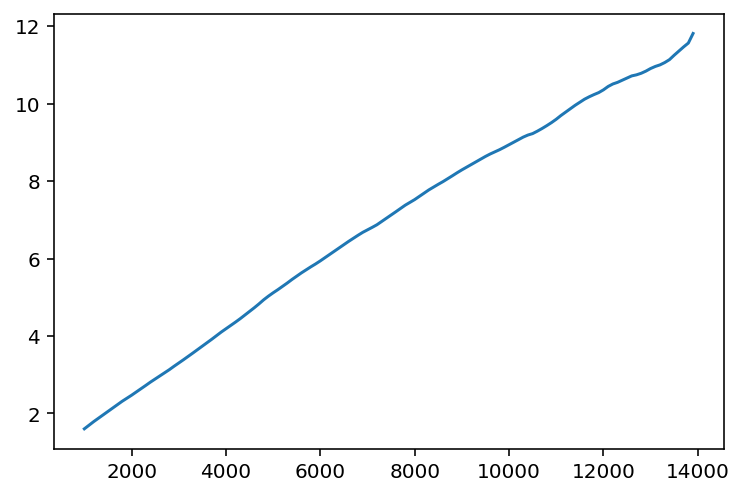

In [4]:
plt.plot(da.dt,da.msd)
plt.show()

In [5]:
data = da.sq_disp_store
# da.sq_disp_store is a list of 2D Numpy arrays. Each array has axes [ion, squared displacement observation]
# There is one array in the list for each dt value (what pymatgen calls `timestep`)
# Note: this can't be a 3D array because we have a different number of displacements at each dt value.
# This gives N_ions x N_observations displacements at each dt.
# BUT the N_observations are not independent, because pymatgen calculates *all* possible displacements over dt.
# Therefore if dt = 10, the number of non-overlapping measurements is N_observations / 10
# To estimate the number of independent observations 
# (used to set the number of samples in the bootstrap resampling)
# we therefore calculate n_observations / dt * n_ions.
# Where n_observations is an integer multiple of dt this gives the exact number of non-overlapping
# observations per ion
# For non-integer multiples we linearly interpolate between the two adjacent integer multiple values
# Which gives a smooth change in the number of samples, and also approximates the effect of including
# partially overlapping observations (e.g. if N_obs = 100, and dt = 51, there first and last observations
# are only 2% correlated)
max_obs = data[0].shape[1]
std_err = np.array([])
ci = []
n_sets = 2000 # number of data sets to resample
n_steps = len(da.dt)
all_data = np.zeros((len(data), 2000))
all_data_flat = np.array([])
dt_flat = np.array([])
for j, d in enumerate(data):
    n_obs = d.shape[1]
    n_ions = d.shape[0]
    dt = max_obs - n_obs + 1
    n_samples = int(max_obs/dt*n_ions) # approximate number of "non-overlapping" observations, allowing for partial overlap
    sampled_means = [np.mean(resample(d.flatten(), n_samples=n_samples)) for i in range(n_sets)]
    all_data[j, :] = np.array(sampled_means)
    all_data_flat = np.append(all_data_flat, sampled_means)
    dt_flat = np.append(dt_flat, np.ones_like(sampled_means) * da.dt[j])
    # std error for the mean squared displacement at dt
    std_err = np.append(std_err, np.std(sampled_means))
    # 2.5% and 97.5% percentile values for the mean squared displacement at dt
    ci.append([np.percentile(sampled_means, 2.5), np.percentile(sampled_means, 97.5)])

<ErrorbarContainer object of 3 artists>

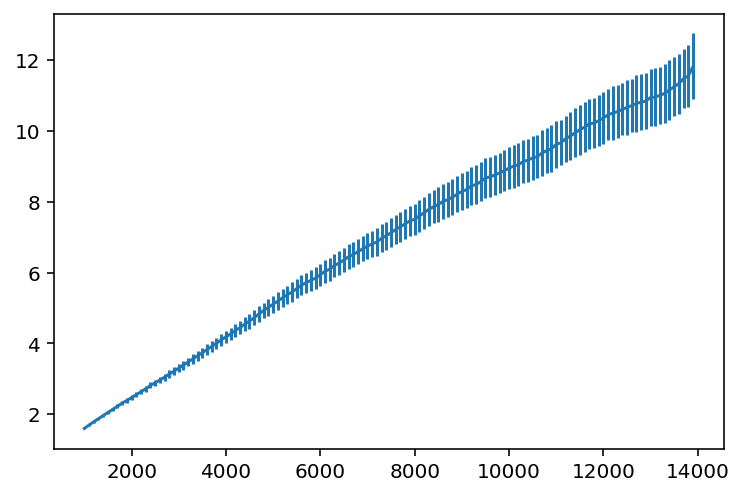

In [6]:
plt.errorbar(da.dt, all_data.mean(axis=1), all_data.std(axis=1))

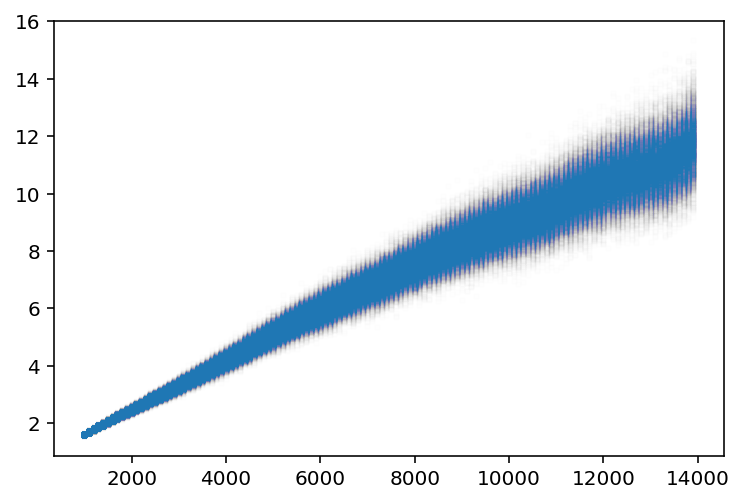

In [7]:
plt.plot(dt_flat, all_data_flat, '.', alpha=0.005)

In [8]:
num_points = 2600
num_samples = 2000

In [9]:
a = np.random.randint(0, all_data.shape[0], size=(num_samples, num_points))
b = np.random.randint(0, all_data.shape[1], size=(num_samples, num_points))

s1 = da.dt[a].sum(axis=1)
s2 = np.square(da.dt[a]).sum(axis=1)
cxy = np.multiply(da.dt[a], all_data[a, b]).sum(axis=1)
cy = all_data[a, b].sum(axis=1)

In [10]:
m = (num_points * cxy - s1 * cy) / (num_points * s2 - s1 ** 2)

In [11]:
c = (s2 * cy - s1 * cxy) / (num_points * s2 - s1 ** 2)

In [12]:
ps = np.array([m, c]).T

In [13]:
import corner

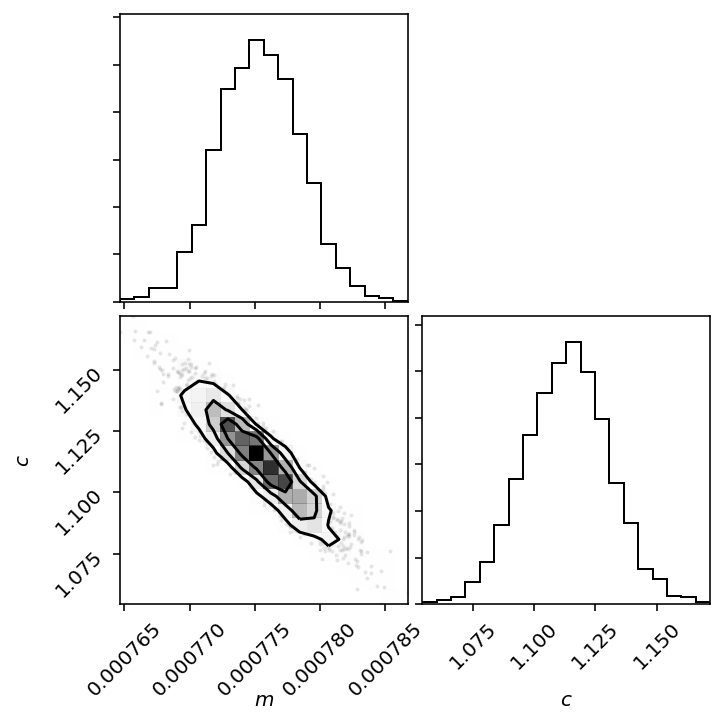

In [14]:
fig = corner.corner(ps, labels=[r"$m$", r"$c$"])

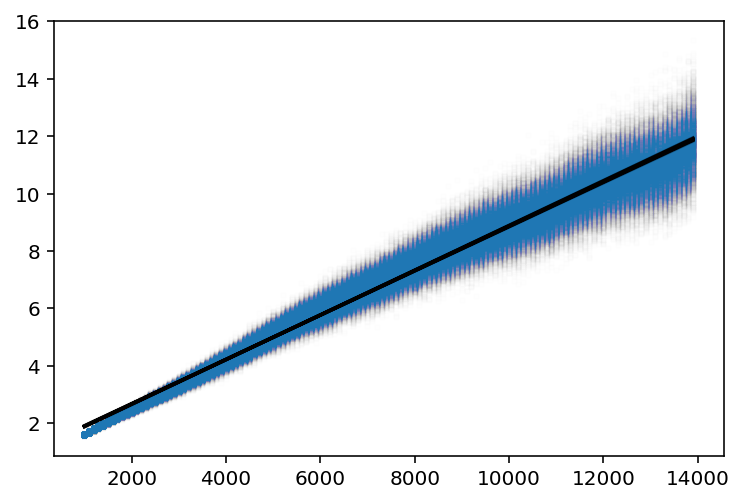

In [15]:
j = np.random.choice(range(0, m.size), size=100)
plt.plot(dt_flat, all_data_flat, '.', alpha=0.005)
for i in j:
    plt.plot(da.dt, m[i] * da.dt + c[i], 'k-', alpha=0.1)
plt.show()

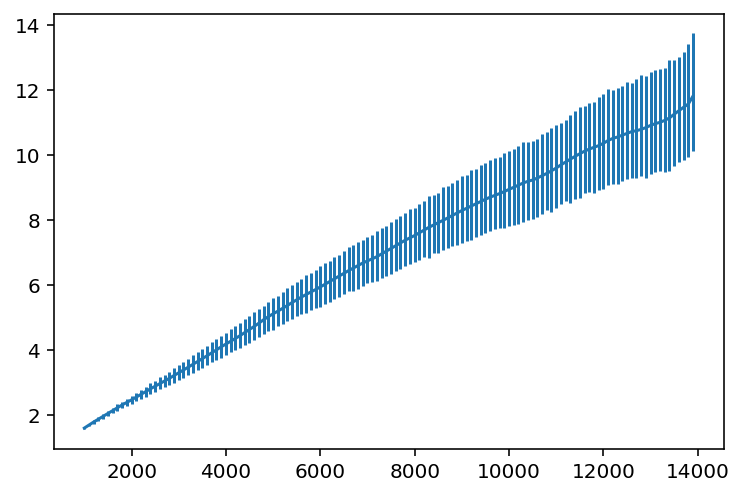

In [16]:
ci_arr = np.array(ci).T
y_error = np.array([da.msd - ci_arr[0], ci_arr[1] - da.msd])
plt.errorbar(da.dt, da.msd, yerr=y_error)
plt.show()

The Shapiro-Wilk test is an off-the-shelf statistical test for normality in a distribution.
It can get false answer for **massive** (>5000) distribution, hence the `np.random.choice`.

In [19]:
from scipy.stats import shapiro

In [20]:
def check_normality(sample, label='Sample'):
    """
    Quick sanity check with a Shapiro-Wilk test
    
    Args:
        sample (list): distribution to test
        label (string): name for the distribution
    """
    sub_sample = np.random.choice(sample, size=2500)
    stat, p = shapiro(sub_sample)
    alpha = 0.05
    if p > alpha:
        print('{} looks Gaussian (fail to reject H0)'.format(label))
    else:
        print('{} does not look Gaussian (reject H0)'.format(label))

In [21]:
check_normality(m, 'm')
check_normality(c, 'c')

m looks Gaussian (fail to reject H0)
c looks Gaussian (fail to reject H0)


If everything is normally distributed, then we can describe the distributions with means and standard deviations.

In [22]:
print('gradient: {:.3e}±{:.3e}'.format(np.mean(ps[:, 0]), np.std(ps[:, 0])))
print('intercept: {:.3e}±{:.3e}'.format(np.mean(ps[:, 1]), np.std(ps[:, 1])))

gradient: 7.754e-04±3.125e-06
intercept: 1.113e+00±1.713e-02


Therefore from DOI: [10.1038/s41524-018-0074-y](https://doi.org/10.1038/s41524-018-0074-y), 

$$ m = 2dD, $$

where, $d$ is the dimensionality, and $D$ is the diffusivity. 

In [23]:
D = np.mean(ps[:, 0]) / (2 * 3)
D_err = np.std(ps[:, 0]) / (2 * 3)
print('diffusivity: {:.3e}±{:.3e}'.format(D, D_err))

diffusivity: 1.292e-04±5.209e-07


While $D_{\text{offset}}$ is equal to $c$.

In [24]:
D_off = np.mean(ps[:, 1])
D_off_err = np.std(ps[:, 1])
print('D_offset: {:.3e}±{:.3e}'.format(D_off, D_off_err))

D_offset: 1.113e+00±1.713e-02
